<center>
<h1> SOLUCIÓN TAREA 17 - Métodos no Supervisados (clustering)
</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

Importamos las librerias necesarias para trabajar:

In [ ]:
import numpy as np
from scipy.cluster import vq
import cv2
import matplotlib.pyplot as plt

Cargamos la imagen:

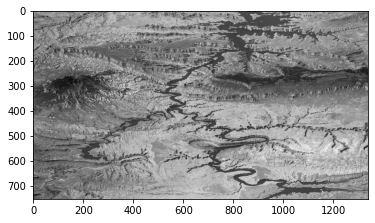

In [ ]:
img=cv2.imread('./Mapa.jpg',0)
plt.imshow(img, cmap='gray')
plt.show()

Se implementara como una función de OpenCV, el algoritmo de clasificación no supervisado ISODATA, de esta manera empezamos definiendo algunas funciones que nos seran de utilidad:

In [ ]:
def initialize_parameters(parameters=None):
    """
    Función auxiliar para establecer valores por defecto a todos los parámetros que no
    no se les ha dado un valor por parte del usuario.
    """
    parameters = {} if not parameters else parameters

    def safe_pull_value(parameters, key, default):
        return parameters.get(key, default)

    # Numero de Clusters deseados
    K = safe_pull_value(parameters, 'K', 5)

    # maximo de iteraciones
    I = safe_pull_value(parameters, 'I', 100)

    # máximo número de pares de clusters que pueden ser fusionados
    P = safe_pull_value(parameters, 'P', 4)

    # valor umbral para el número mínimo de muestras en cada cluster
    # (descartando clusters)
    THETA_M = safe_pull_value(parameters, 'THETA_M', 10)

    # valor de umbral para la desviación estándar (para la división)
    THETA_S = safe_pull_value(parameters, 'THETA_S', 1)
    # valor de umbral para las distancias entre pares (para la fusión)
    THETA_C = safe_pull_value(parameters, 'THETA_C', 20)

    #porcentaje de cambio en los clusters entre cada iteración
    #(para detener el algoritmo)
    THETA_O = 0.05

    #puede utilizar cualquiera de los dos fijos o aleatorios
    #número de conglomerados iniciales
    #k = np.random.randint(1, K)
    k = safe_pull_value(parameters, 'k', K)

    ret = locals()
    ret.pop('safe_pull_value')
    ret.pop('parameters')
    globals().update(ret)

In [ ]:
def quit_low_change_in_clusters(centers, last_centers, iter):
    """
    Detener el algoritmo por bajo cambio en los valores de los clusters entre cada
    iteración.

    Devuelve: True si debe detenerse, en caso contrario False.

    """
    quit = False
    if centers.shape == last_centers.shape:
        thresholds = np.abs((centers - last_centers) / (last_centers + 1))

        if np.all(thresholds <= THETA_O):  # percent of change in [0:1]
            quit = True
    return quit

In [ ]:
def merge_clusters(img_class_flat, centers, clusters_list):
    """
    Fusionar por pares de clusters en 'below_threshold' para formar nuevos clusters.
    """
    pair_dists = compute_pairwise_distances(centers)

    first_p_elements = pair_dists[:P]

    below_threshold = [(c1, c2) for d, (c1, c2) in first_p_elements
                                if d < THETA_C]

    if below_threshold:
        k = centers.size
        count_per_cluster = np.zeros(k)
        to_add = np.array([])  # nuevos clusters a añadir
        to_delete = np.array([]) # clusters a eliminar

        for cluster in range(0, k):
            result = np.where(img_class_flat == clusters_list[cluster])
            indices = result[0]
            count_per_cluster[cluster] = indices.size

        for c1, c2 in below_threshold:
            c1_count = float(count_per_cluster[c1]) + 1
            c2_count = float(count_per_cluster[c2])
            factor = 1.0 / (c1_count + c2_count)
            weight_c1 = c1_count * centers[c1]
            weight_c2 = c2_count * centers[c2]

            value = round(factor * (weight_c1 + weight_c2))

            to_add = np.append(to_add, value)
            to_delete = np.append(to_delete, [c1, c2])

        #eliminar los clusters antiguos y sus índices de la matriz de disponibles
        centers = np.delete(centers, to_delete)
        clusters_list = np.delete(clusters_list, to_delete)

        #generar nuevos índices para los nuevos clusters
        #comenzando por el índice máximo 'to_add.size' veces
        start = int(clusters_list.max())
        end = to_add.size + start

        centers = np.append(centers, to_add)
        clusters_list = np.append(clusters_list, range(start, end))

        centers, clusters_list = sort_arrays_by_first(centers, clusters_list)

    return centers, clusters_list

In [ ]:
def compute_pairwise_distances(centers):
    """
    Calcula las distancias por pares 'pair_dists', entre cada dos clusters
    y las devuelve ordenadas.
    Devuelve
           - una lista con tuplas, donde cada tupla tiene en su primera coordenada la
             distancia entre los clusters, y en la segunda coordenada tiene una tupla
             con los números de los clusters medidos.
    """
    pair_dists = []
    size = centers.size

    for i in range(0, size):
        for j in range(0, size):
            if i > j:
                d = np.abs(centers[i] - centers[j])
                pair_dists.append((d, (i, j)))

    #devolverlo ordenado en el primer elemento
    return sorted(pair_dists)

In [ ]:
def split_clusters(img_flat, img_class_flat, centers, clusters_list):
    """
    Dividir los clusters para formar nuevos clusters.
    """
    assert centers.size == clusters_list.size, \
        "ERROR: split() centers and clusters_list size are different"

    delta = 10
    k = centers.size
    count_per_cluster = np.zeros(k)
    stddev = np.array([])

    avg_dists_to_clusters = compute_avg_distance(img_flat, img_class_flat,
                                                 centers, clusters_list)
    d = compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                                 clusters_list)

    # calcula todas las desviaciones estándar de los clusters
    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size
        value = ((img_flat[indices] - centers[cluster]) ** 2).sum()
        value /= count_per_cluster[cluster]
        value = np.sqrt(value)
        stddev = np.append(stddev, value)

    cluster = stddev.argmax()
    max_stddev = stddev[cluster]
    max_clusters_list = int(clusters_list.max())

    if max_stddev > THETA_S:
        if avg_dists_to_clusters[cluster] >= d:
            if count_per_cluster[cluster] > (2.0 * THETA_M):
                old_cluster = centers[cluster]
                new_cluster_1 = old_cluster + delta
                new_cluster_2 = old_cluster - delta

                centers = np.delete(centers, cluster)
                clusters_list = np.delete(clusters_list, cluster)

                centers = np.append(centers, [new_cluster_1, new_cluster_2])
                clusters_list = np.append(clusters_list, [max_clusters_list,
                                          (max_clusters_list + 1)])

                centers, clusters_list = sort_arrays_by_first(centers,
                                                              clusters_list)

                assert centers.size == clusters_list.size, \
                   "ERROR: split() centers and clusters_list size are different"

    return centers, clusters_list

In [ ]:
def compute_overall_distance(img_class_flat, avg_dists_to_clusters,
                             clusters_list):
    """
    Calcula la distancia global de las muestras a sus respectivos centros de cluster
    respectivos.
    """
    k = avg_dists_to_clusters.size
    total = img_class_flat.size
    count_per_cluster = np.zeros(k)

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        count_per_cluster[cluster] = indices.size

    d = ((count_per_cluster / total) * avg_dists_to_clusters).sum()

    return d

In [ ]:
def compute_avg_distance(img_flat, img_class_flat, centers, clusters_list):
    """
    Calcula todas las distancias medias al centro en cada cluster.
    """
    k = centers.size
    avg_dists_to_clusters = np.array([])

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]

        total_per_cluster = indices.size + 1
        sum_per_cluster = (np.abs(img_flat[indices] - centers[cluster])).sum()

        dj = (sum_per_cluster / float(total_per_cluster))

        avg_dists_to_clusters = np.append(avg_dists_to_clusters, dj)

    return avg_dists_to_clusters

In [ ]:
def discard_clusters(img_class_flat, centers, clusters_list):
    """
    Descarta los grupos con menos de THETA_M.
    """
    k = centers.shape[0]
    to_delete = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        total_per_cluster = indices.size
        if total_per_cluster <= THETA_M:
            to_delete = np.append(to_delete, cluster)

    if to_delete.size:
        new_centers = np.delete(centers, to_delete)
        new_clusters_list = np.delete(clusters_list, to_delete)
    else:
        new_centers = centers
        new_clusters_list = clusters_list

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: discard_cluster() centers and clusters_list size are different"

    return new_centers, new_clusters_list

In [ ]:
def update_clusters(img_flat, img_class_flat, centers, clusters_list):
    """ Actualizar clusters. """
    k = centers.shape[0]
    new_centers = np.array([])
    new_clusters_list = np.array([])

    assert centers.size == clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    for cluster in range(0, k):
        indices = np.where(img_class_flat == clusters_list[cluster])[0]
        #get whole cluster
        cluster_values = img_flat[indices]
        #sum and count the values
        sum_per_cluster = cluster_values.sum()
        total_per_cluster = (cluster_values.size) + 1
        #compute the new center of the cluster
        new_cluster = sum_per_cluster / total_per_cluster

        new_centers = np.append(new_centers, new_cluster)
        new_clusters_list = np.append(new_clusters_list, cluster)

    new_centers, new_clusters_list = sort_arrays_by_first(new_centers,
                                                          new_clusters_list)

    assert new_centers.size == new_clusters_list.size, \
        "ERROR: update_clusters() centers and clusters_list size are different"

    return new_centers, new_clusters_list

In [ ]:
def initial_clusters(img_flat, k, method="linspace"):
    """
    Define los centros iniciales de los clusters como inicio.
    Por defecto, el método es "linspace". Otro método disponible es "aleatorio".
    """
    methods_availables = ["linspace", "random"]

    assert method in methods_availables, "ERROR: method %s is no valid." \
                                         "Methods availables %s" \
                                         % (method, methods_availables)
    if method == "linspace":
        max, min = img_flat.max(), img_flat.min()
        centers = np.linspace(min, max, k)
    elif method == "random":
        start, end = 0, img_flat.size
        indices = np.random.randint(start, end, k)
        centers = img_flat.take(indices)

    return centers

In [ ]:
def sort_arrays_by_first(centers, clusters_list):
    """
    Ordenar el array 'centros' y el con los índices de los centros ordenados
    ordenan el array 'clusters_list'.
    Ejemplo: centers=[22, 33, 0, 11] y cluster_list=[7,6,5,4]
    devuelve (array([ 0, 11, 22, 33]), array([5, 4, 7, 6])
    """
    assert centers.size == clusters_list.size, \
    "ERROR: sort_arrays_by_first centers and clusters_list size are not equal"

    indices = np.argsort(centers)

    sorted_centers = centers[indices]
    sorted_clusters_list = clusters_list[indices]

    return sorted_centers, sorted_clusters_list

In [ ]:
def isodata_classification(img, parameters=None):
    """
    Clasifica un numpy 'img' usando el algoritmo Isodata.
    Parámetros: un diccionario con las siguientes claves.
            - img: un array numpy de entrada que contiene la imagen a clasificar.
            - parámetros: un diccionario con los valores iniciales.
              Si no se especifica 'parameters', el algoritmo utiliza los valores por defecto
              los.
                  + número de clusters deseados.
                    K = 15
                  + número máximo de iteraciones.
                    I = 100
                  + número máximo de pares de clusters que pueden ser ,ergidos.
                    P = 2
                  + valor de umbral para el número mínimo en cada cluster.
                    THETA_M = 10
                  + valor del umbral para la desviación estándar (para la división).
                    THETA_S = 0.1
                  + valor del umbral para las distancias entre pares (para la fusión).
                    THETA_C = 2
                  + valor umbral de cambio de los clusters entre cada iter.
                    THETA_O = 0,01
        Nota: si algunos (o todos) los parámetros no se proporcionan, se utilizarán los valores por defecto.
              se utilizarán los valores por defecto.
    Devuelve:
            - img_class: un array numpy con la clasificación.
    """
    global K, I, P, THETA_M, THETA_S, THEHTA_C, THETA_O, k
    initialize_parameters(parameters)

    N, M = img.shape # para la remodelación al final
    img_flat = img.flatten()
    clusters_list = np.arange(k)  # número de clusters disponibles

    print("Isodata(info): Starting algorithm with %s classes" % k)
    centers = initial_clusters(img_flat, k, "linspace")

    for iter in range(0, I):
        last_centers = centers.copy()
        #asignar cada una de las muestras al centro de cluster más cercano
        img_class_flat, dists = vq.vq(img_flat, centers)

        centers, clusters_list = discard_clusters(img_class_flat,
                                                  centers, clusters_list)
        centers, clusters_list = update_clusters(img_flat,
                                                 img_class_flat,
                                                 centers, clusters_list)
        k = centers.size

        if k <= (K / 2.0):  # muy pocos clusters => dividir clusters
            centers, clusters_list = split_clusters(img_flat, img_class_flat,
                                                    centers, clusters_list)

        elif k > (K * 2.0):  # demasiados clusters => fusionar clusters
            centers, clusters_list = merge_clusters(img_class_flat, centers,
                                                    clusters_list)
        else:  # nor split or merge are needed
            pass

        k = centers.size
        if quit_low_change_in_clusters(centers, last_centers, iter):
            break

    print("Isodata(info): Finished with %s classes" % k)
    print("Isodata(info): Number of Iterations: %s" % (iter + 1))

    return img_class_flat.reshape(N, M)

In [ ]:
def equalize_histogram(img, histogram, cfs):
    """
    Iguala los valores de los píxeles a [0:255].
    """
    total_pixels = img.size
    N, M = img.shape
    min_value = img.min()
    L = 256  # Number of levels of grey
    cfs_min = cfs.min()
    img_corrected = np.zeros_like(img)
    corrected_values = np.zeros_like(histogram)

    divisor = np.float32(total_pixels) - np.float32(cfs_min)

    if not divisor:  # this happens when the image has all the values equals
        divisor = 1.0

    factor = (np.float32(L) - 1.0) / divisor

    corrected_values = ((np.float32(cfs) -
                         np.float32(cfs_min)) * factor).round()

    img_copy = np.uint64(img - min_value)
    img_corrected = corrected_values[img_copy]

    return img_corrected

In [ ]:
def equalization_using_histogram(img):

    # Create histogram, bin edges and cumulative distributed function
    max_value = img.max()
    min_value = img.min()

    assert min_value >= 0, \
        "ERROR: equalization_using_histogram() img have negative values!"

    start, stop, step = int(min_value), int(max_value + 2), 1

    histogram, bin_edge = np.histogram(img, range(start, stop, step))
    cfs = histogram.cumsum()  # cumulative frencuency table
    img_corrected = equalize_histogram(img, histogram, cfs)

    return img_corrected

Una vez establecido el algoritmo ISODATA y las funciones procedemos a probar con dos imágenes:

Isodata(info): Starting algorithm with 2 classes
Isodata(info): Finished with 2 classes
Isodata(info): Number of Iterations: 2


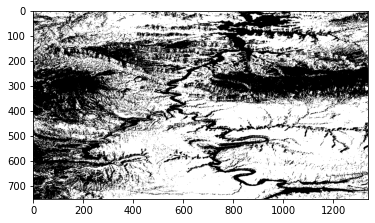

In [ ]:
#Establecemos los parametros
params = {"K": 2, "I" : 100, "P" : 2, "THETA_M" : 10, "THETA_S" : 0.1,
          "THETA_C" : 2, "THETA_O" : 0.01}

# Corremos el Isodata con la imagen cargada
class_image = isodata_classification(img, parameters=params)

# Ecualizamos
class_image_eq = equalization_using_histogram(class_image)

# Observamos
plt.imshow(class_image_eq, cmap='gray')

Para distintas cantidades de clusters:

In [ ]:
resultados=[]
for vari in range(2,10):
  #Establecemos los parametros
  params = {"K": vari, "I" : 100, "P" : 2, "THETA_M" : 10, "THETA_S" : 0.1,
            "THETA_C" : 2, "THETA_O" : 0.01}

  # Corremos el Isodata con la imagen cargada
  class_image = isodata_classification(img, parameters=params)

  # Ecualizamos
  class_image_eq = equalization_using_histogram(class_image)

  resultados.append(class_image_eq)

Isodata(info): Starting algorithm with 2 classes
Isodata(info): Finished with 2 classes
Isodata(info): Number of Iterations: 2
Isodata(info): Starting algorithm with 3 classes
Isodata(info): Finished with 3 classes
Isodata(info): Number of Iterations: 4
Isodata(info): Starting algorithm with 4 classes
Isodata(info): Finished with 4 classes
Isodata(info): Number of Iterations: 5
Isodata(info): Starting algorithm with 5 classes
Isodata(info): Finished with 5 classes
Isodata(info): Number of Iterations: 6
Isodata(info): Starting algorithm with 6 classes
Isodata(info): Finished with 6 classes
Isodata(info): Number of Iterations: 5
Isodata(info): Starting algorithm with 7 classes
Isodata(info): Finished with 7 classes
Isodata(info): Number of Iterations: 7
Isodata(info): Starting algorithm with 8 classes
Isodata(info): Finished with 8 classes
Isodata(info): Number of Iterations: 7
Isodata(info): Starting algorithm with 9 classes
Isodata(info): Finished with 9 classes
Isodata(info): Number o

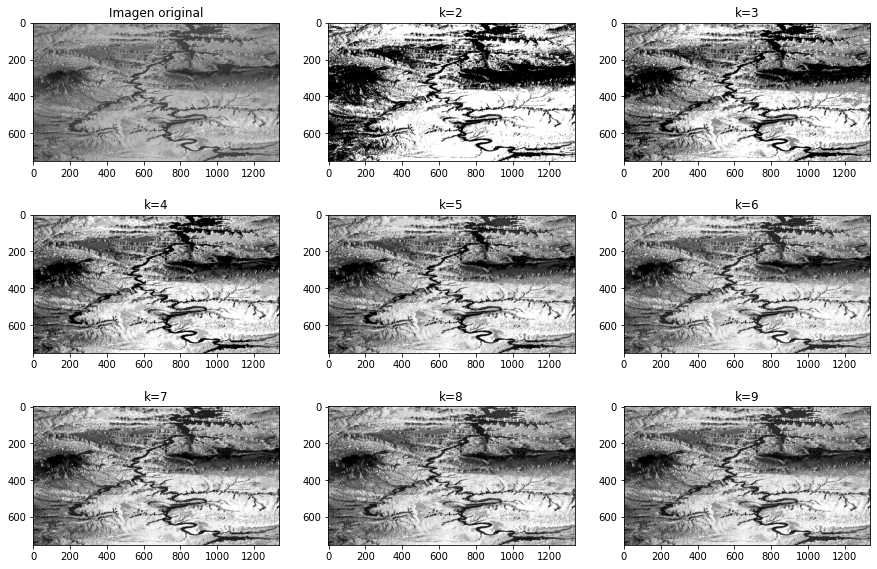

In [ ]:
plt.figure(1,figsize=(15,10))
plt.subplot(331).imshow(img,cmap='gray')
plt.title('Imagen original')
for i in range(2,10):
  plt.subplot(3,3,i).imshow(resultados[i-2],cmap='gray')
  plt.title(f'k={i}')

In [ ]:
resultados=[]
img2=cv2.imread('./Personas.jpg',0)
for vari in range(2,10):
  #Establecemos los parametros
  params = {"K": vari, "I" : 100, "P" : 2, "THETA_M" : 10, "THETA_S" : 0.1,
            "THETA_C" : 2, "THETA_O" : 0.01}

  # Corremos el Isodata con la imagen cargada
  class_image = isodata_classification(img2, parameters=params)

  # Ecualizamos
  class_image_eq = equalization_using_histogram(class_image)

  resultados.append(class_image_eq)

Isodata(info): Starting algorithm with 2 classes
Isodata(info): Finished with 2 classes
Isodata(info): Number of Iterations: 2
Isodata(info): Starting algorithm with 3 classes
Isodata(info): Finished with 3 classes
Isodata(info): Number of Iterations: 3
Isodata(info): Starting algorithm with 4 classes
Isodata(info): Finished with 4 classes
Isodata(info): Number of Iterations: 5
Isodata(info): Starting algorithm with 5 classes
Isodata(info): Finished with 5 classes
Isodata(info): Number of Iterations: 4
Isodata(info): Starting algorithm with 6 classes
Isodata(info): Finished with 6 classes
Isodata(info): Number of Iterations: 6
Isodata(info): Starting algorithm with 7 classes
Isodata(info): Finished with 7 classes
Isodata(info): Number of Iterations: 5
Isodata(info): Starting algorithm with 8 classes
Isodata(info): Finished with 8 classes
Isodata(info): Number of Iterations: 4
Isodata(info): Starting algorithm with 9 classes
Isodata(info): Finished with 9 classes
Isodata(info): Number o

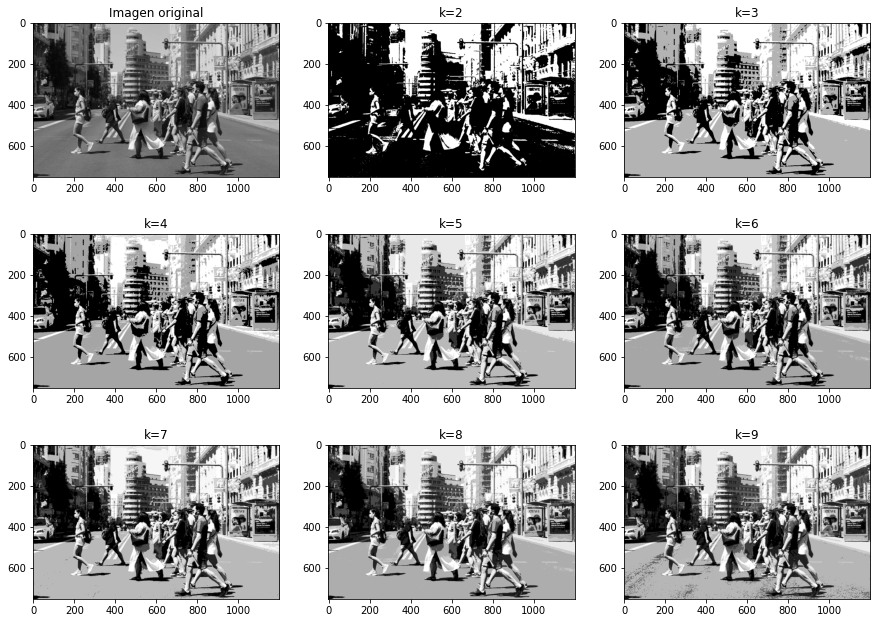

In [ ]:
plt.figure(1,figsize=(15,11))
plt.subplot(331).imshow(img2,cmap='gray')
plt.title('Imagen original')
for i in range(2,10):
  plt.subplot(3,3,i).imshow(resultados[i-2],cmap='gray')
  plt.title(f'k={i}')

Vemos como el algoritmo ISODATA realiza la clusterización de manera no supervisada para diferentes valores de k dados unos parámetros.